In [28]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import json
import csv
import sys
import time
from lib import bitmex
from lib.bitmex import BitMEX
from settings import API_BASE, API_KEY, API_SECRET
import scipy as sp
from scipy.stats import *
from scipy.stats import skew, kurtosis
from scipy.signal import *

4294967296

11.39335297196024

In [232]:
def pnl_alpha_X(start, end, name, alpha, sleep, leverage, low, high, X):
    


    # Create connector
    connector = bitmex.BitMEX(base_url=API_BASE)

    # Do trade history query
    path = "trade/bucketed?binSize=5m&symbol=XBTUSD&columns=symbol%2C%20timestamp%2C%20close%2C%20high%2C%20low"
    count = 500  # max API will allow
    query = {
        'reverse': 'true',
        'start': start,
        'count': count,
        }

    csvwriter = None
    with open(name, 'w+') as f:
        while True:
            data = connector._curl_bitmex(path=path, verb="GET", query=query, timeout=5)
            if sleep > 0:
                time.sleep(2.1)
            if csvwriter is None:
                # csv requires dict keys
                if len(data) == 0:
                    break
                keys = sorted(data[0].keys())
                # Write to stdout
                csvwriter = csv.DictWriter(f, fieldnames=keys)
                csvwriter.writeheader()

            csvwriter.writerows(data)
            #data2 = pd.DataFrame
            data2 = np.append(data, data)
            query['start'] += count
            if query['start'] > end:
                break
            if len(data) < count:
                break

    df1 = pd.read_csv(name)
    df_all = pd.DataFrame(df1)
    df_all = pd.DataFrame(df_all.values[::-1], df_all.index, df_all.columns) # turn around data

    close = df_all['close'] #close values
    #vwap = pd.Series(df_all['vwap']) #volume-weighted price average
    lm = len(close)-1
    lp = len(close)+1
    l = len(close)
    rsi_len = 15
    ## RSI CLOSE ##
    change_close = pd.Series(np.zeros(l))
    gain = pd.Series(np.zeros(l))
    loss = pd.Series(np.zeros(l))
    smagain = pd.Series(np.zeros(l))
    smaloss = pd.Series(np.zeros(l))
    RS = pd.Series(np.zeros(l))
    RSIclose = pd.Series(np.zeros(l))
    for i in range(1,len(close)):   
        #print(close[i])
        change_close[i] = close[i]-close[i-1]
        if change_close[i] > 0:
            gain[i] = change_close[i]
        elif change_close[i] < 0:
            loss[i] = change_close[i]*-1
        elif change_close[i] == 0.00000:
            loss[i] = 0
            gain[i] = 0
        if i == rsi_len:   
            smagain[rsi_len] = gain[i-rsi_len:i].sum()/rsi_len
            smaloss[rsi_len] = loss[i-rsi_len:i].sum()/rsi_len
        elif i > rsi_len: 
            smagain[i] = (1-alpha)*smagain[i-1]+(alpha)*gain[i]
            smaloss[i] = (1-alpha)*smaloss[i-1]+(alpha)*loss[i]
            if smaloss[i] == 0:
                RSIclose[i] = 100
            else:
                RS[i] = smagain[i]/smaloss[i]
                RSIclose[i] = 100 - 100/(1+RS[i])
               #print(RSIclose[i])
    j = 0
    k = 0
    price = np.zeros((l-15, 9))
    #pnl = 1;
    f=0
    d=0
    for i in range(15, l):
        if (RSIclose[i] < low and j == 0):
            j = 1
            price[k, 0] = close[i]
            price[k, 2] = i
            price[k, 4] = RSIclose[i]
        elif (RSIclose[i]>=high) and (j>=1):
            #mat[j,k] = RSIclose[i]
            price[k, 5] = RSIclose[i]
            price[k, 3] = i;   
            price[k, 1] = close[i]
            price[k, 8] = (1-price[k,1]/price[k,0])*100
            k = k+1
            j = 0
       # d = 1
    price = np.delete(price, np.s_[k::], 0)
    pnl = np.ones(len(price))
    pnlT = np.ones(len(price))
    X2= abs(X-1)
    for i in range(0, len(price)-1):
        pnl[i] = (1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
        pnlT[i+1] = pnlT[i]*(1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
        price[i, 7] = pnlT[i]
        price[i, 6] = pnl[i]
    plt.plot(range(1,len(pnl)+1), pnlT, label='Boys per Time')
    plt.title("Boys Club Now")
    plt.legend()
    plt.show()
    #n, bins, patches = plt.hist(pnl, 500, density=False, facecolor='g', alpha=0.85)
    n, bins, patches = plt.hist(pnl, 500, density=False, facecolor='g', alpha=0.85)
    #print(min(price))
    print(np.argmax(price[:,8]))
    print(np.max(price[:,8]))
    print(np.mean(pnl))
    print(sp.stats.skew(pnl))
    print(max(pnl))
    print(min(pnl))
    print(pnlT[(len(pnlT) - 1)])
    #pdb.set_trace()g

In [52]:
pnl_alpha_X

<function __main__.pnl_alpha_X(start, end, name, alpha, sleep, leverage, low, high, X)>

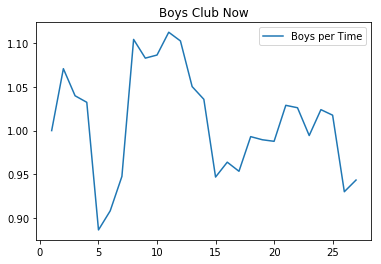

3
1.2593395999035861
0.9993232250945238
0.24280949395777782
1.1647752808988772
0.8590660400096414
0.9436337271966658


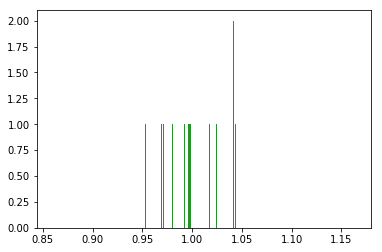

In [233]:
pnl_alpha_X(0, 1440, '1440_May21.csv', 0.4,  0, 10, 10, 90, 1)

In [112]:
## just RSIalpha and PNL ##

alpha = 0.3
low = 40
high = 60
leverage = 10



In [110]:
price[:,5]

array([80.37257091, 84.87879577, 70.90231099, ..., 90.97357711,
       76.78933176, 92.26714021])

In [ ]:
#print(close)

In [ ]:
print(RSIclose)

In [58]:
dFdt = pd.Series(np.zeros(l))
dFdtFil = pd.Series(np.zeros(l))
for i in range(1, len(fil)):
    dFdt[i] = fil[i]-fil[i-1]
dFdtFil = sp.signal.savgol_filter(dFdt, 35, 3)

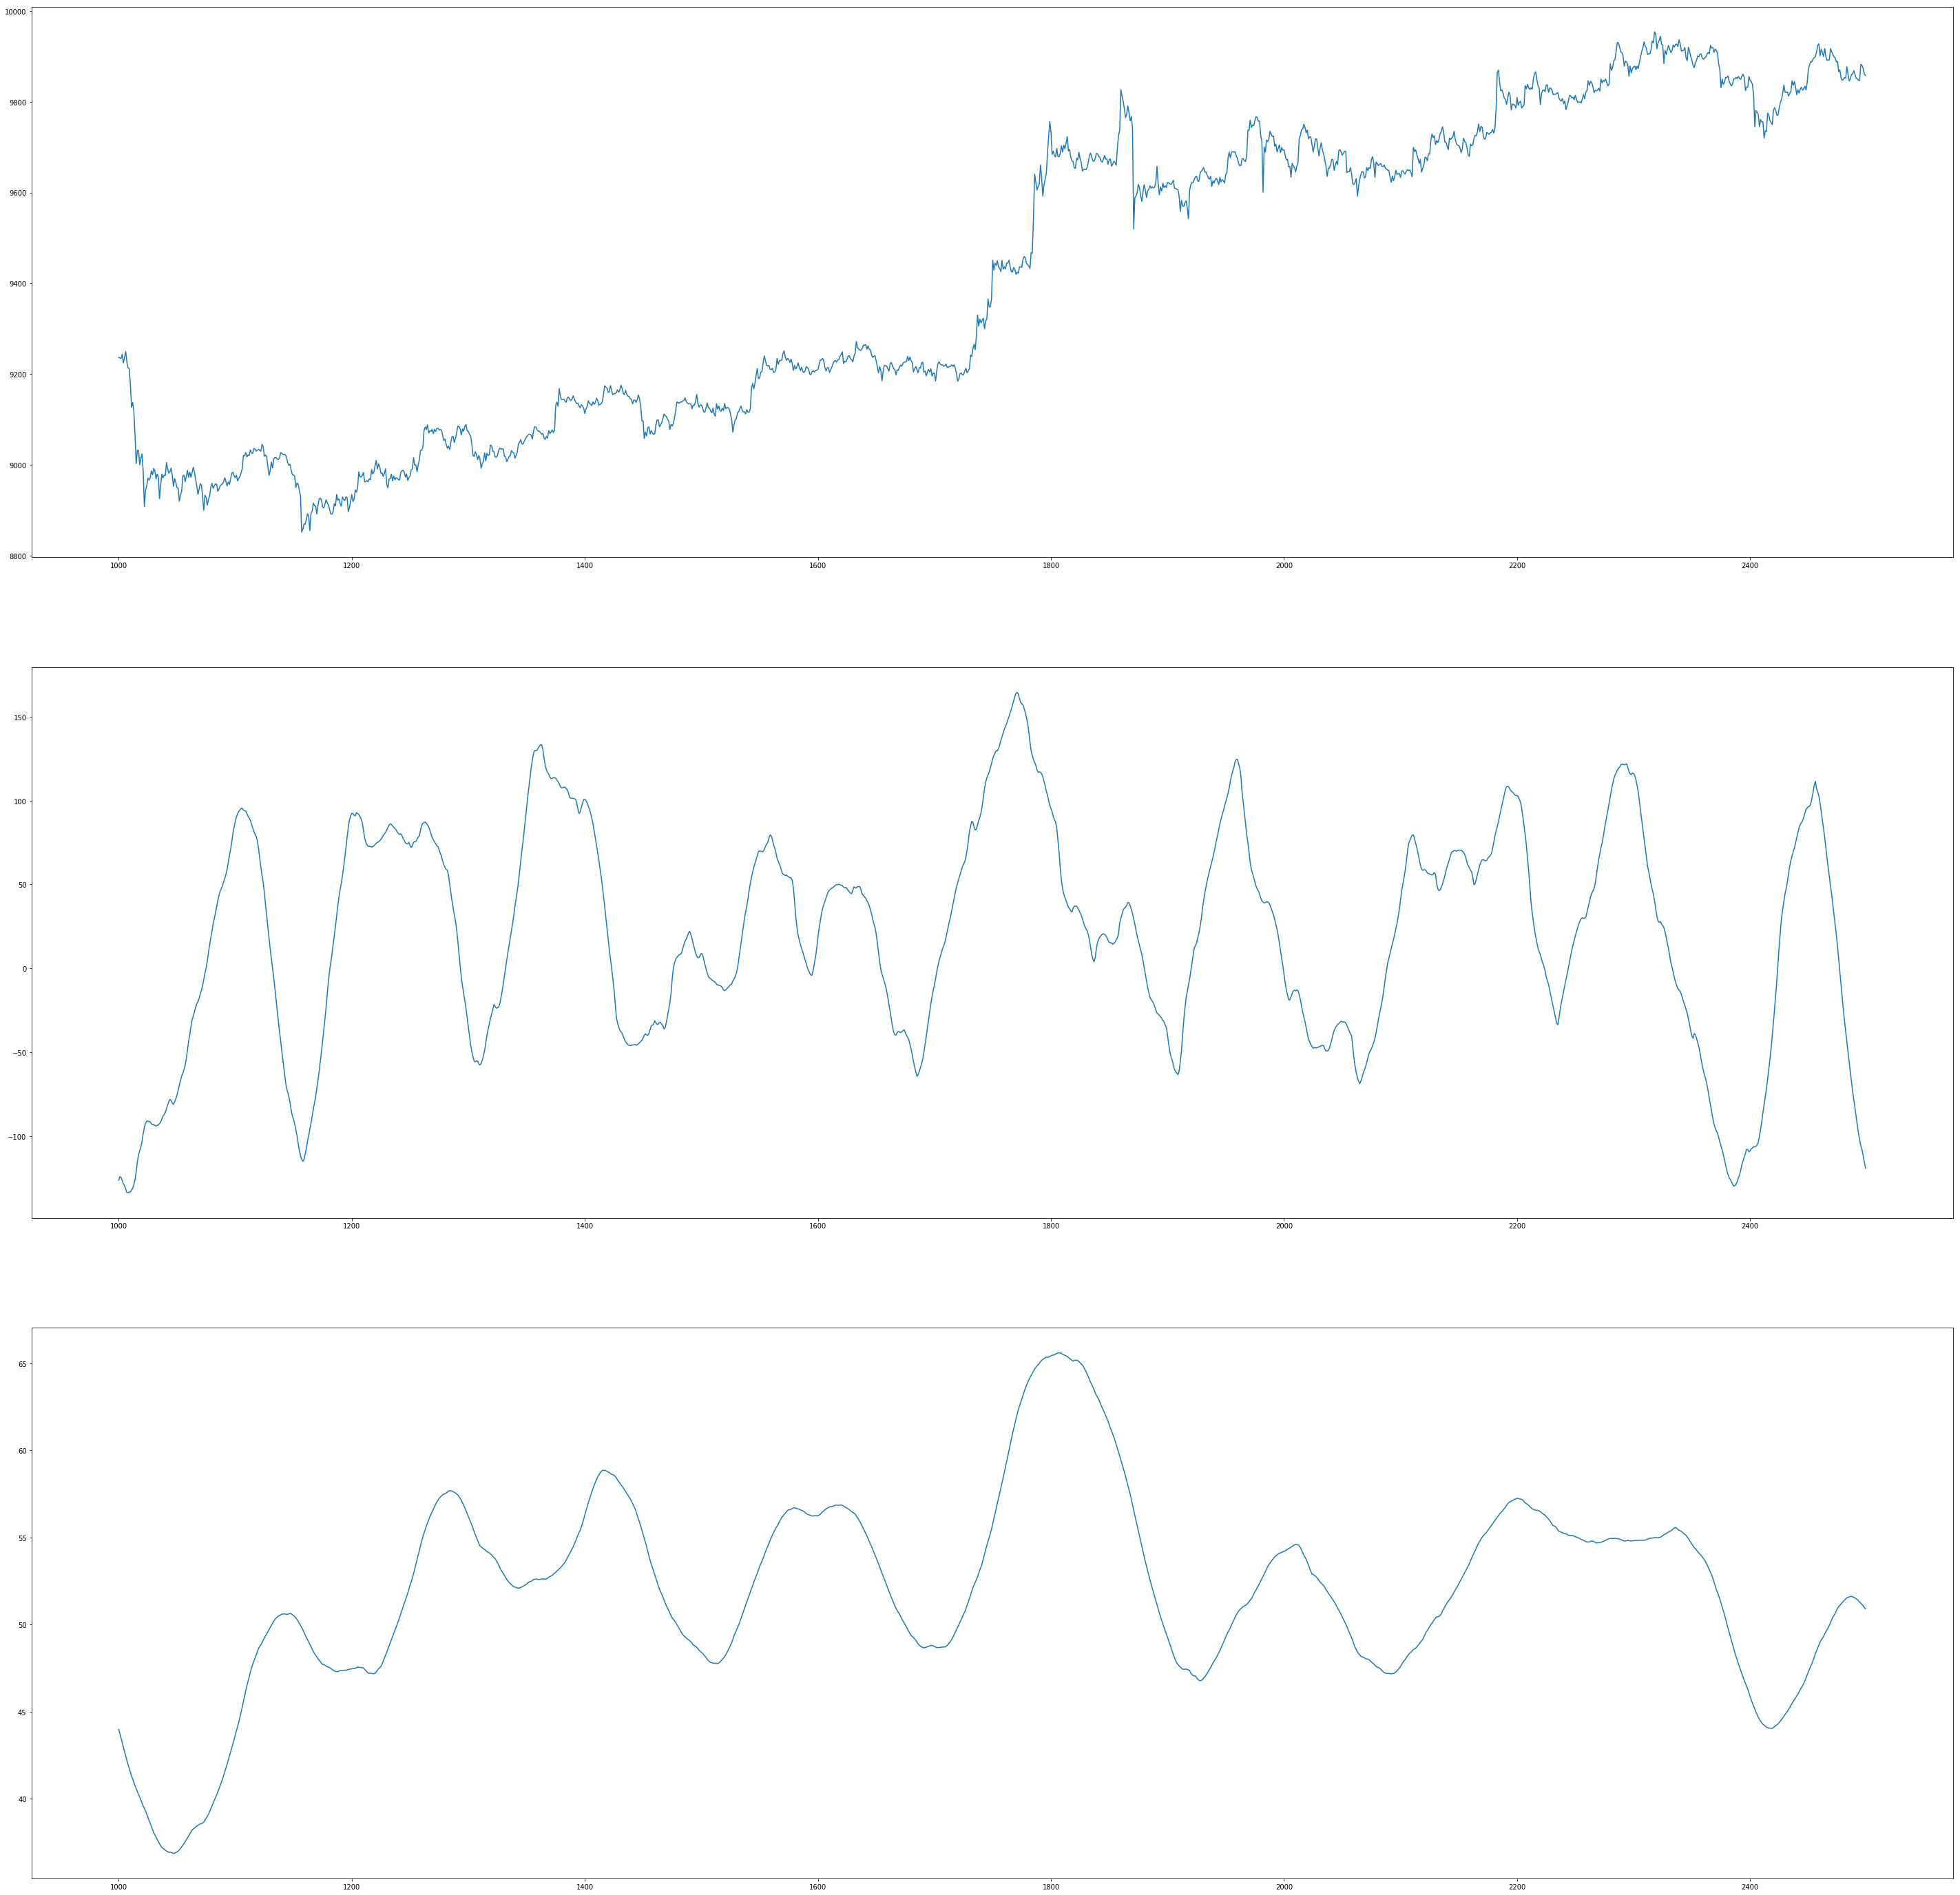

In [129]:

## THERE'S SOMETHING HERE ####

fil = sp.signal.savgol_filter(RSI100, 105, 3)
dFdt = pd.Series(np.zeros(l))
dF2 = pd.Series(np.zeros(l))
for i in range(1, len(fil)):
    dFdt[i] = fil[i]-fil[i-1]
    dF2[i] = dFdt[i] - dFdt[i-1]
dFdt = sp.signal.savgol_filter(dFdt, 25, 3)
dF2 = sp.signal.savgol_filter(dF2, 75, 3)
CCIsav = sp.signal.savgol_filter(CCI, 105, 3)
plt.rcParams['figure.figsize'] = [50, 50]

m = 3
J = np.arange(1000, 2500)
plt.subplot(m,1,1)
plt.plot(J, close[J])
#plt.subplot(5,1,2)
#plt.plot(J, CCI[J])
plt.subplot(m,1,2)
plt.plot(J, CCIsav[J])
#plt.subplot(4,1,2)
#plt.plot(J, CCI[J])
plt.subplot(m,1,3)
plt.plot(J, fil[J])


plt.show()
#print(sp.stats.skew(CCI[J]))

In [ ]:
## Short Only ##

price = np.zeros((l-rsi_len, 9))
#mat = np.zeros((20, 1200))
#pnl = 1;
#leverage = 10
f=0
d=0
high = 300
low = -300
j = 0
k = 0
price = np.zeros((l-cci_len, 6))
for i in range(cci_len, l):
    if (CCI[i] <= low and j == 0):
        j = 1
        price[k, 0] = close[i]
        price[k, 2] = i
    #elif j == 1 and close[i] <= (.95)*price[k,0]:
    #    j = 0
   #     price[k, 1] = close[i]
   #     price[k, 3] = i
   #     k = k+1
    elif (CCI[i] >= high) and (j==1):
        #mat[j,k] = RSIclose[i]
        price[k, 3] = i 
        price[k, 1] = close[i]
        k = k+1
        j = 0
   # d = 1
price = np.delete(price, np.s_[k::], 0)
pnl = np.ones(len(price))
pnlT = np.ones(len(price))
X = 1
X2= abs(X-1)
for i in range(0, len(price)-1):
    pnl[i] = (1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    pnlT[i+1] = pnlT[i]*(1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    price[i, 4] = pnl[i+1]
    price[i, 5] = pnlT[i+1]
#plt.subplot(2,1,1)
#plt.plot(range())
plt.plot(range(1,len(pnl)+1), pnlT, label='Boys per Time')

plt.show()

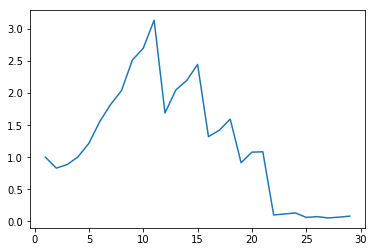

In [206]:
df1 = pd.read_csv('5000.csv') ##read the price data
df_all = pd.DataFrame(df1) ##make into dataframe
df_all = pd.DataFrame(df_all.values[::-1], df_all.index, df_all.columns) # turn around data
close = pd.Series(df_all['close']) #series of close prices
high = pd.Series(df_all['high']) #high
low = pd.Series(df_all['low'])#low values 
l = len(close)
CCI = pd.Series(np.zeros(l)) # initialize matrices
SMA = pd.Series(np.zeros(l)) # " " 
madmat = pd.Series(np.zeros(l)) #  " " 
cci_len=30 #length of CCI period in minutes
TP = (high+low+close)/3 #"Typical Price" #
alpha = 0 ##turn on if i want to change SMA to EWMA
for i in range(cci_len, len(close)):
    SMA[i] =   alpha*(TP[i]) + (1-alpha)*(TP[i-cci_len:i].sum()/cci_len)  ##simple moving average
    madmat[i] = abs(SMA[i]-TP[i])  ##Mean Absolute Deviation
    for j in range(1, cci_len):
        madmat[i] = madmat[i] + abs(SMA[i]-TP[i-j]) ## Mean Absolute Deviation
    madmat[i] = madmat[i]/cci_len ## Mean Absolute Deviation
    CCI[i] = (TP[i]-SMA[i])/(.015*madmat[i]) 
j = 0
k = 0
price = np.zeros((l-rsi_len, 9))
#mat = np.zeros((20, 1200))
#pnl = 1;
#leverage = 10
f=0
d=0
high = 300
low = -300
j = 0
k = 0
price = np.zeros((l-cci_len, 6))
for i in range(cci_len, l):
    if (CCI[i] <= low and j == 0):
        j = 1
        price[k, 0] = close[i]
        price[k, 2] = i
    #elif j == 1 and close[i] <= (.95)*price[k,0]:
    #    j = 0
   #     price[k, 1] = close[i]
   #     price[k, 3] = i
   #     k = k+1
    elif (CCI[i] >= high) and (j==1):
        #mat[j,k] = RSIclose[i]
        price[k, 3] = i 
        price[k, 1] = close[i]
        k = k+1
        j = 0
   # d = 1
price = np.delete(price, np.s_[k::], 0)
pnl = np.ones(len(price))
pnlT = np.ones(len(price))
X = 1
X2= abs(X-1)
for i in range(0, len(price)-1):
    pnl[i] = (1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    pnlT[i+1] = pnlT[i]*(1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    price[i, 4] = pnl[i+1]
    price[i, 5] = pnlT[i+1]
#plt.subplot(2,1,1)
#plt.plot(range())
plt.plot(range(1,len(pnl)+1), pnlT, label='Boys per Time')

plt.show()

In [25]:
## If one positive shock switch? ##

## If ... ... ? ##


##Skewness not necessarily good measure ##

##Back to Volatility as measure? But that doesnt msr neg shocks??##


print(dRdt)

0.0041075203865902354


[ 0.          0.          0.         ... 49.53090151 49.48268613
 49.42321717]


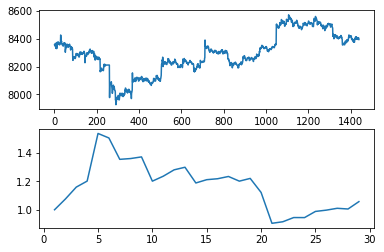

-0.41180248562599275


In [21]:


J = np.arange(1, 1440)
##SHORT##
leverage = 10
lowLong = -200
highLong = 200

highShort = 50
lowShort = -200
j = 0
k = 0
price = np.zeros((l-cci_len, 6))
for i in range(cci_len, l):
   
    # Check if it's going up or down
    




    if LONG = 1:   
    
        if (CCI[i] <= lowLong and j == 0):
            j = 1
            price[k, 0] = close[i]
            price[k, 2] = i

        elif (CCI[i] >= highLong) and (j==1):
            #mat[j,k] = RSIclose[i]
            price[k, 3] = i 
            price[k, 1] = close[i]
            k = k+1
            j = 0
        ## SWITCH ##
        #elif j == 1 and close[i] <= (.95)*price[k,0]:
           # j = 0
            #price[k, 1] = close[i]
            #price[k, 3] = i
            #k = k+1



    if SHORT = 1:
        if (CCI[i] >= highShort and j == 0):
            j = 1
            price[k, 0] = close[i]
            price[k, 2] = i

        elif (CCI[i] <= lowShort) and (j==1):
            #mat[j,k] = RSIclose[i]
            price[k, 3] = i 
            price[k, 1] = close[i]
            k = k+1
            j = 0

    ##SWITCH    
    #elif j == 1 and close[i] <= (.95)*price[k,0] and SHORT = 1:
    #    j = 0
   #     price[k, 1] = close[i]
   #     price[k, 3] = i
   #     k = k+1
price = np.delete(price, np.s_[k::], 0)
pnl = np.ones(len(price))
pnlT = np.ones(len(price))
X = 0
X2= abs(X-1)
for i in range(0, len(price)-1):
    pnl[i] = (1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    pnlT[i+1] = pnlT[i]*(1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    price[i, 4] = pnl[i+1]
    price[i, 5] = pnlT[i+1]
plt.subplot(2,1,1)
plt.plot(J, close[J])
#plt.plot(range())
#plt.subplot(2,1,1)
#plt.plot(range())
plt.subplot(2,1,2)
plt.plot(range(1,len(pnl)+1), pnlT, label='Boys per Time')
plt.show()
print(sp.stats.skew(CCI))

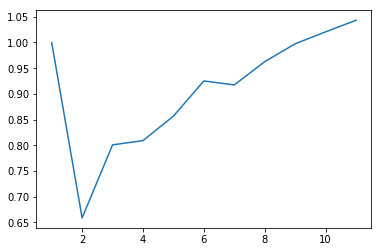

In [18]:
##LONG##

high = 200
low = -200
j = 0
k = 0
price = np.zeros((l-cci_len, 6))
for i in range(cci_len, l):
    if (CCI[i] <= low and j == 0):
        j = 1
        price[k, 0] = close[i]
        price[k, 2] = i
    elif (CCI[i] >= high) and (j==1):
        price[k, 3] = i 
        price[k, 1] = close[i]
        k = k+1
        j = 0
price = np.delete(price, np.s_[k::], 0)
pnl = np.ones(len(price))
pnlT = np.ones(len(price))
X = 1
X2= abs(X-1)
for i in range(0, len(price)-1):
    pnl[i] = (1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    pnlT[i+1] = pnlT[i]*(1+(price[i,X]/price[i,X2]-1-.00075*2)*leverage)
    price[i, 4] = pnl[i+1]
    price[i, 5] = pnlT[i+1]
#plt.subplot(2,1,1)
#plt.plot(range())
plt.plot(range(1,len(pnl)+1), pnlT, label='Boys per Time')

plt.show()

In [92]:
df1 = pd.read_csv('1440_7_Jun2.csv')
df_all = pd.DataFrame(df1)
df_all = pd.DataFrame(df_all.values[::-1], df_all.index, df_all.columns) # turn around data

close = pd.Series(df_all['close'])
high = pd.Series(df_all['high'])
low = pd.Series(df_all['low'])#close values 
l = len(close)
CCI = pd.Series(np.zeros(l))
dCdt = pd.Series(np.zeros(l))
SMA = pd.Series(np.zeros(l))
madmat = pd.Series(np.zeros(l))
cci_len=30
TP = (high+low+close)/3
for i in range(cci_len, len(close)):
    SMA[i] = TP[i-cci_len:i].sum()/cci_len
    madmat[i] = abs(SMA[i]-TP[i])
    for j in range(1, cci_len):
        madmat[i] = madmat[i] + abs(SMA[i]-TP[i-j])
    madmat[i] = madmat[i]/cci_len
    CCI[i] = (TP[i]-SMA[i])/(.015*madmat[i])
j = 0
k = 0

#mat = np.zeros((20, 1200))
#pnl = 1;
#leverage = 10
f=0
d=0
rsi_len = 100
change_close = pd.Series(np.zeros(l))
gain = pd.Series(np.zeros(l))
loss = pd.Series(np.zeros(l))
smagain = pd.Series(np.zeros(l))
smaloss = pd.Series(np.zeros(l))
RS = pd.Series(np.zeros(l))
RSIclose = pd.Series(np.zeros(l))
dRdt = pd.Series(np.zeros(l))
dR2dt = pd.Series(np.zeros(l))
for i in range(1,len(close)):   
    #print(close[i])
    change_close[i] = close[i]-close[i-1]
    if change_close[i] > 0:
        gain[i] = change_close[i]
    elif change_close[i] < 0:
        loss[i] = change_close[i]*-1
    elif change_close[i] == 0.00000:
        loss[i] = 0
        gain[i] = 0
    if i == rsi_len:   
        smagain[rsi_len] = gain[i-rsi_len:i].sum()/rsi_len
        smaloss[rsi_len] = loss[i-rsi_len:i].sum()/rsi_len
    elif i > rsi_len: 
        smagain[i] = gain[i-rsi_len:i].sum()/rsi_len
        smaloss[i] = loss[i-rsi_len:i].sum()/rsi_len
        if smaloss[i] == 0:
            RSIclose[i] = 100
        else:
            RS[i] = smagain[i]/smaloss[i]
            RSIclose[i] = 100 - 100/(1+RS[i])
           #print(RSIclose[i])

In [83]:

## RSI 100 ##

rsi_len_100 = 100
rsi_len_50 = 50
rsi_len_25 = 25
change_close = pd.Series(np.zeros(l))
gain = pd.Series(np.zeros(l))
loss = pd.Series(np.zeros(l))
smagain = pd.Series(np.zeros(l))
smaloss = pd.Series(np.zeros(l))
RS = pd.Series(np.zeros(l))
RSI100 = pd.Series(np.zeros(l))
dRdt = pd.Series(np.zeros(l))
dR2dt = pd.Series(np.zeros(l))
for i in range(1,len(close)):   
    #print(close[i])
    change_close[i] = close[i]-close[i-1]
    if change_close[i] > 0:
        gain[i] = change_close[i]
    elif change_close[i] < 0:
        loss[i] = change_close[i]*-1
    elif change_close[i] == 0.00000:
        loss[i] = 0
        gain[i] = 0
    if i == rsi_len_100:   
        smagain[rsi_len_100] = gain[i-rsi_len_100:i].sum()/rsi_len
        smaloss[rsi_len_100] = loss[i-rsi_len_100:i].sum()/rsi_len
    elif i > rsi_len_100: 
        smagain[i] = gain[i-rsi_len_100:i].sum()/rsi_len
        smaloss[i] = loss[i-rsi_len_100:i].sum()/rsi_len
        if smaloss[i] == 0:
            RSI100[i] = 100
        else:
            RS[i] = smagain[i]/smaloss[i]
            RSI100[i] = 100 - 100/(1+RS[i])
           #print(RSIclose[i])

In [4]:

## RSI 50 ##

rsi_len_100 = 100
rsi_len_50 = 50
rsi_len_25 = 25
change_close = pd.Series(np.zeros(l))
gain = pd.Series(np.zeros(l))
loss = pd.Series(np.zeros(l))
smagain = pd.Series(np.zeros(l))
smaloss = pd.Series(np.zeros(l))
RS = pd.Series(np.zeros(l))
RSI50 = pd.Series(np.zeros(l))
dRdt = pd.Series(np.zeros(l))
dR2dt = pd.Series(np.zeros(l))
for i in range(1,len(close)):   
    #print(close[i])
    change_close[i] = close[i]-close[i-1]
    if change_close[i] > 0:
        gain[i] = change_close[i]
    elif change_close[i] < 0:
        loss[i] = change_close[i]*-1
    elif change_close[i] == 0.00000:
        loss[i] = 0
        gain[i] = 0
    if i == rsi_len_50:   
        smagain[rsi_len_50] = gain[i-rsi_len_50:i].sum()/rsi_len
        smaloss[rsi_len_50] = loss[i-rsi_len_50:i].sum()/rsi_len
    elif i > rsi_len_50: 
        smagain[i] = gain[i-rsi_len_50:i].sum()/rsi_len
        smaloss[i] = loss[i-rsi_len_50:i].sum()/rsi_len
        if smaloss[i] == 0:
            RSI50[i] = 100
        else:
            RS[i] = smagain[i]/smaloss[i]
            RSI50[i] = 100 - 100/(1+RS[i])

           #print(RSIclose[i])

In [10]:

## RSI 25 ##

rsi_len_100 = 100
rsi_len_50 = 50
rsi_len_25 = 25
change_close = pd.Series(np.zeros(l))
gain = pd.Series(np.zeros(l))
loss = pd.Series(np.zeros(l))
smagain = pd.Series(np.zeros(l))
smaloss = pd.Series(np.zeros(l))
RS = pd.Series(np.zeros(l))
RSI25 = pd.Series(np.zeros(l))
dRdt = pd.Series(np.zeros(l))
dR2dt = pd.Series(np.zeros(l))
for i in range(1,len(close)):   
    #print(close[i])
    change_close[i] = close[i]-close[i-1]
    if change_close[i] > 0:
        gain[i] = change_close[i]
    elif change_close[i] < 0:
        loss[i] = change_close[i]*-1
    elif change_close[i] == 0.00000:
        loss[i] = 0
        gain[i] = 0
    if i == rsi_len_25:   
        smagain[rsi_len_25] = gain[i-rsi_len_25:i].sum()/rsi_len
        smaloss[rsi_len_25] = loss[i-rsi_len_25:i].sum()/rsi_len
    elif i > rsi_len_25: 
        smagain[i] = gain[i-rsi_len_25:i].sum()/rsi_len
        smaloss[i] = loss[i-rsi_len_25:i].sum()/rsi_len
        if smaloss[i] == 0:
            RSI25[i] = 100
        else:
            RS[i] = smagain[i]/smaloss[i]
            RSI25[i] = 100 - 100/(1+RS[i])
           #print(RSIclose[i])

In [4]:
df1 = pd.read_csv('1440_7-14_Jun3.csv')
df_all = pd.DataFrame(df1)
df_all = pd.DataFrame(df_all.values[::-1], df_all.index, df_all.columns) # turn around data

close = pd.Series(df_all['close'])
high = pd.Series(df_all['high'])
low = pd.Series(df_all['low'])#close values 
l = len(close)
CCI = pd.Series(np.zeros(l))
dCdt = pd.Series(np.zeros(l))
SMA = pd.Series(np.zeros(l))
madmat = pd.Series(np.zeros(l))
cci_len=50
TP = (high+low+close)/3
for i in range(cci_len, len(close)):
    SMA[i] = TP[i-cci_len:i].sum()/cci_len
    madmat[i] = abs(SMA[i]-TP[i])
    for j in range(1, cci_len):
        madmat[i] = madmat[i] + abs(SMA[i]-TP[i-j])
    madmat[i] = madmat[i]/cci_len
    CCI[i] = (TP[i]-SMA[i])/(.015*madmat[i])
j = 0
k = 0

#mat = np.zeros((20, 1200))
#pnl = 1;
#leverage = 10
f=0
d=0
rsi_len = 100
change_close = pd.Series(np.zeros(l))
gain = pd.Series(np.zeros(l))
loss = pd.Series(np.zeros(l))
smagain = pd.Series(np.zeros(l))
smaloss = pd.Series(np.zeros(l))
RS = pd.Series(np.zeros(l))
RSIclose = pd.Series(np.zeros(l))
dRdt = pd.Series(np.zeros(l))
dR2dt = pd.Series(np.zeros(l))
for i in range(1,len(close)):   
    #print(close[i])
    change_close[i] = close[i]-close[i-1]
    if change_close[i] > 0:
        gain[i] = change_close[i]
    elif change_close[i] < 0:
        loss[i] = change_close[i]*-1
    elif change_close[i] == 0.00000:
        loss[i] = 0
        gain[i] = 0
    if i == rsi_len:   
        smagain[rsi_len] = gain[i-rsi_len:i].sum()/rsi_len
        smaloss[rsi_len] = loss[i-rsi_len:i].sum()/rsi_len
    elif i > rsi_len: 
        smagain[i] = gain[i-rsi_len:i].sum()/rsi_len
        smaloss[i] = loss[i-rsi_len:i].sum()/rsi_len
        if smaloss[i] == 0:
            RSIclose[i] = 100
        else:
            RS[i] = smagain[i]/smaloss[i]
            RSIclose[i] = 100 - 100/(1+RS[i])
            dRdt[i] = RS[i]-RS[i-1]
           #print(RSIclose[i])

In [79]:
def dl(start, end, name):
    # Create connector
    connector = bitmex.BitMEX(base_url=API_BASE)

    # Do trade history query
    path = "trade/bucketed?binSize=5m&symbol=XBTUSD&columns=symbol%2C%20timestamp%2C%20close%2C%20high%2C%20low"
    count = 500  # max API will allow
    query = {
        'reverse': 'true',
        'start': start,
        'count': count,
        }

    csvwriter = None
    with open(name, 'w+') as f:
        while True:
            data = connector._curl_bitmex(path=path, verb="GET", query=query, timeout=5)
            if csvwriter is None:
                # csv requires dict keys
                if len(data) == 0:
                    break
                keys = sorted(data[0].keys())
                # Write to stdout
                csvwriter = csv.DictWriter(f, fieldnames=keys)
                csvwriter.writeheader()

            csvwriter.writerows(data)
            #data2 = pd.DataFrame
            data2 = np.append(data, data)
            query['start'] += count
            if query['start'] > end:
                break
            if len(data) < count:
                break


In [81]:
M = 7
dl(M*1440, 2*1440*M, '1440_7-14_Jun3.csv')

In [11]:
df1 = pd.read_csv('1440Jun2.csv')
df_all = pd.DataFrame(df1)
df_all = pd.DataFrame(df_all.values[::-1], df_all.index, df_all.columns) # turn around data

close = pd.Series(df_all['close'])
high = pd.Series(df_all['high'])
low = pd.Series(df_all['low'])#close values 
l = len(close)

In [12]:
len(close)

1500

0